# Assignment 3

## Digital Musicology

@authors: Joris Monnet, Xingyu Pan, Yutaka Osaki, Yiwei Liu

Due Date: 15/05/2024

### Task C1

### Function to distinguish phrases based on volume using midi file

In [2]:
from music21 import converter
import matplotlib.pyplot as plt
import music21
import math
from music21 import converter, meter, stream


In [3]:
def get_volume(midi_file):
    """
    Extracts the velocity values (volume) of each note from a MIDI file.

    Parameters:
    midi_file (music21.stream.Score): The input MIDI file represented as a music21 Score object.
    
    Returns:
    velocities (list of int): A list containing the velocity values of all the notes in the MIDI file.
    """
    velocities = []
    for part in midi_file.parts:
        for note in part.flatten().notes:
            if note.isNote:
                velocities.append(note.volume.velocity)
            elif note.isChord:
                for _ in note.pitches:
                    velocities.append(note.volume.velocity)
    return velocities

In [4]:
def get_scaled_differences_in_volumes(list_volume_performed):
    """
    Calculates the squared differences in volume between consecutive elements
    in the input list, and scales these differences to the range [0, 1].

    Parameters:
    list_volume_performed (list of int or float): A list of volume values.

    Returns:
    list_volume_differences_scaled (list of float): A list of scaled squared differences in volume, 
                                                     where the values are normalized to the range [0, 1].
    """
    list_volume_differences = [abs(list_volume_performed[i] - list_volume_performed[i+1]) **2
                               for i in range(len(list_volume_performed) - 1)]
    max_difference = max(list_volume_differences)
    list_volume_differences_scaled = [x / max_difference for x in list_volume_differences]
    return list_volume_differences_scaled


In [42]:
def get_times_volumes_measures(midi_file_path):
    """
    Extracts the start times, velocity values (volume), and measure numbers of each note from a MIDI file.

    Parameters:
    midi_file_path (str): The path to the input MIDI file.
    
    Returns:
    times (list of float): A list containing the start times of all the notes in the MIDI file.
    volumes (list of int): A list containing the velocity values of all the notes in the MIDI file.
    measures (list of int): A list containing the measure numbers of all the notes in the MIDI file.
    """
    midi_data = music21.converter.parse(midi_file_path)
    
    times = []
    volumes = []
    measures = []

    for part in midi_data.parts:
        for element in part.flatten().notesAndRests:
            if isinstance(element, music21.note.Note):
                start_time = element.offset
                velocity = element.volume.velocity
                measure_number = element.measureNumber
                times.append(start_time)
                volumes.append(velocity)
                measures.append(measure_number)
            elif isinstance(element, music21.chord.Chord):
                start_time = element.offset
                velocity = element.volume.velocity
                measure_number = element.measureNumber
                times.append(start_time)
                volumes.append(velocity)
                measures.append(measure_number)

    return times, volumes, measures

In [131]:
def get_times_threshold(list_time, list_volume_differences_scaled, threshold):
    """
    Function to return the times when volume changes exceed a specified threshold.

    Args:
    list_time (list of float): List of times.
    list_volume_differences_scaled (list of float): List of scaled volume differences.
    threshold (float): The threshold value.

    Returns:
    list of float: List of times when volume changes exceed the threshold.
    """
    
    # List to store indices where the volume difference exceeds the threshold
    indices_above_threshold = [index for index, value in enumerate(list_volume_differences_scaled) if value > threshold]
    
    # List to store times corresponding to the indices above threshold
    times_above_threshold = [list_time[index] for index in indices_above_threshold]
    
    # Return the list of times when volume changes exceed the threshold
    return times_above_threshold


In [132]:
def offset_to_seconds(offset, tempo):
    """
    Converts a musical offset to seconds based on the given tempo.

    Args:
    offset (float): The musical offset in terms of quarter notes.
    tempo (float): The tempo in beats per minute (BPM).

    Returns:
    float: The equivalent time in seconds.
    """
    
    # Calculate the duration of one quarter note in seconds
    quarter_note_duration = 60 / tempo
    # Calculate and return the time in seconds for the given offset
    return offset * quarter_note_duration


In [85]:
midi_data = music21.converter.parse('asap-dataset/Schubert/Moment_Musical_no_1/MunA10M.mid')
tempo = midi_data.metronomeMarkBoundaries()[0][2].number

In [86]:
midi_file_path = 'asap-dataset/Schubert/Moment_Musical_no_1/MunA10M.mid'
list_time, list_volumes, list_measures = get_times_volumes_measures(midi_file_path)
list_volume_differences_scaled = get_scaled_differences_in_volumes(list_volumes)
times_above_threshold_ = get_times_threshold(list_time, list_volume_differences_scaled, 0.15)
times_above_threshold = [float(x) for x in times_above_threshold_]
filtered_data = []
threshold_closest = 2

filtered_data = [times_above_threshold[0]]
for i in range(1, len(times_above_threshold)):
    if times_above_threshold[i] - filtered_data[-1] > threshold_closest:
        filtered_data.append(times_above_threshold[i])

In [133]:
[offset_to_seconds(x, tempo) for x in filtered_data]

[33.333333333333336,
 41.75,
 51.125,
 63.833333333333336,
 75.875,
 87.875,
 97.16666666666667,
 102.625,
 121.125,
 142.20833333333334,
 143.33333333333334,
 158.75,
 162.20833333333334,
 192.91666666666666,
 205.25,
 206.95833333333334,
 212.45833333333334,
 234.75,
 241.91666666666666,
 253.58333333333334,
 256.5833333333333,
 260.4583333333333,
 278.4583333333333,
 282.125,
 293.5833333333333,
 304.0833333333333,
 311.7083333333333,
 312.7916666666667,
 314.4583333333333,
 331.9583333333333]

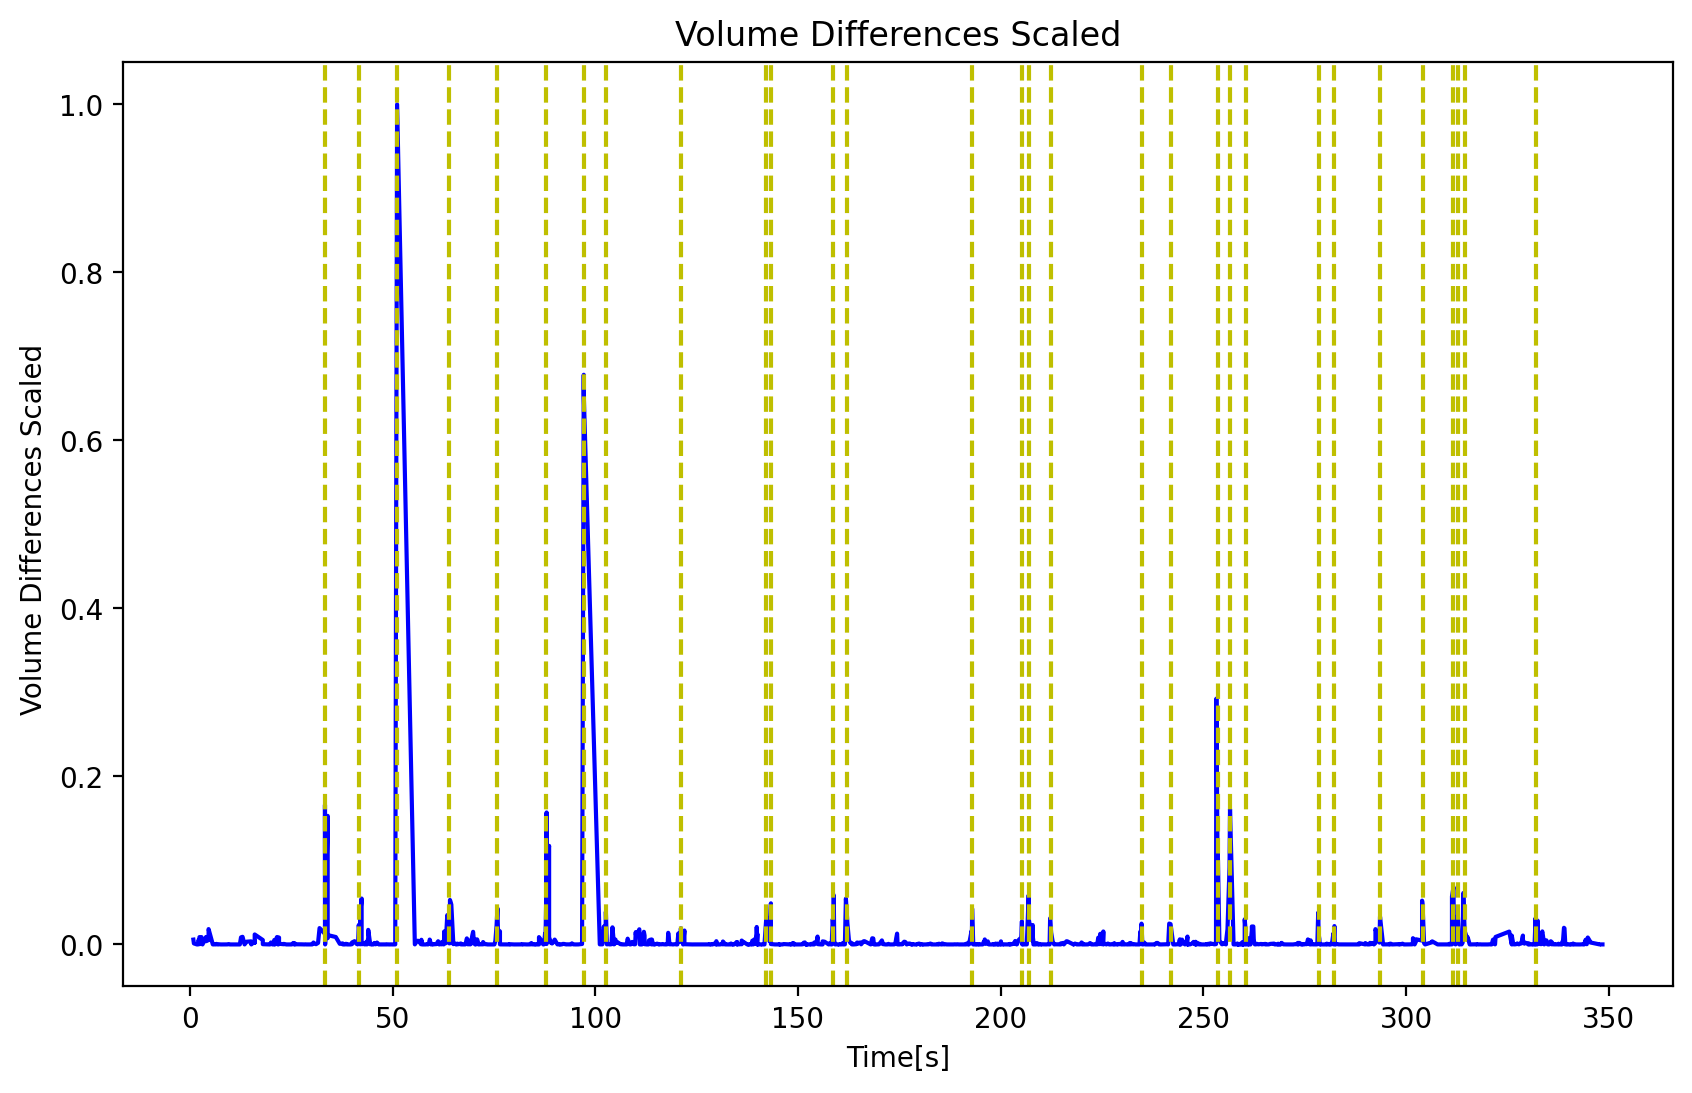

In [87]:
def plot_volume(list_volume_performed, filtered_data, list_time, tempo):
    list_time_second = [offset_to_seconds(x, tempo) for x in list_time]
    list_filtered_second = [offset_to_seconds(x, tempo) for x in filtered_data]
    list_volume_differences_scaled = get_scaled_differences_in_volumes(list_volume_performed)
    plt.figure(figsize=(10, 6))
    plt.plot(list_time_second[:-2], list_volume_differences_scaled, linestyle='-', color='b')
    for x in list_filtered_second:
        plt.axvline(x=x, color='y', linestyle='--')
    plt.xlabel('Time[s]')
    plt.ylabel('Volume Differences Scaled ')
    plt.title('Volume Differences Scaled')
    plt.show()

plot_volume(list_volume_differences_scaled, filtered_data, list_time)

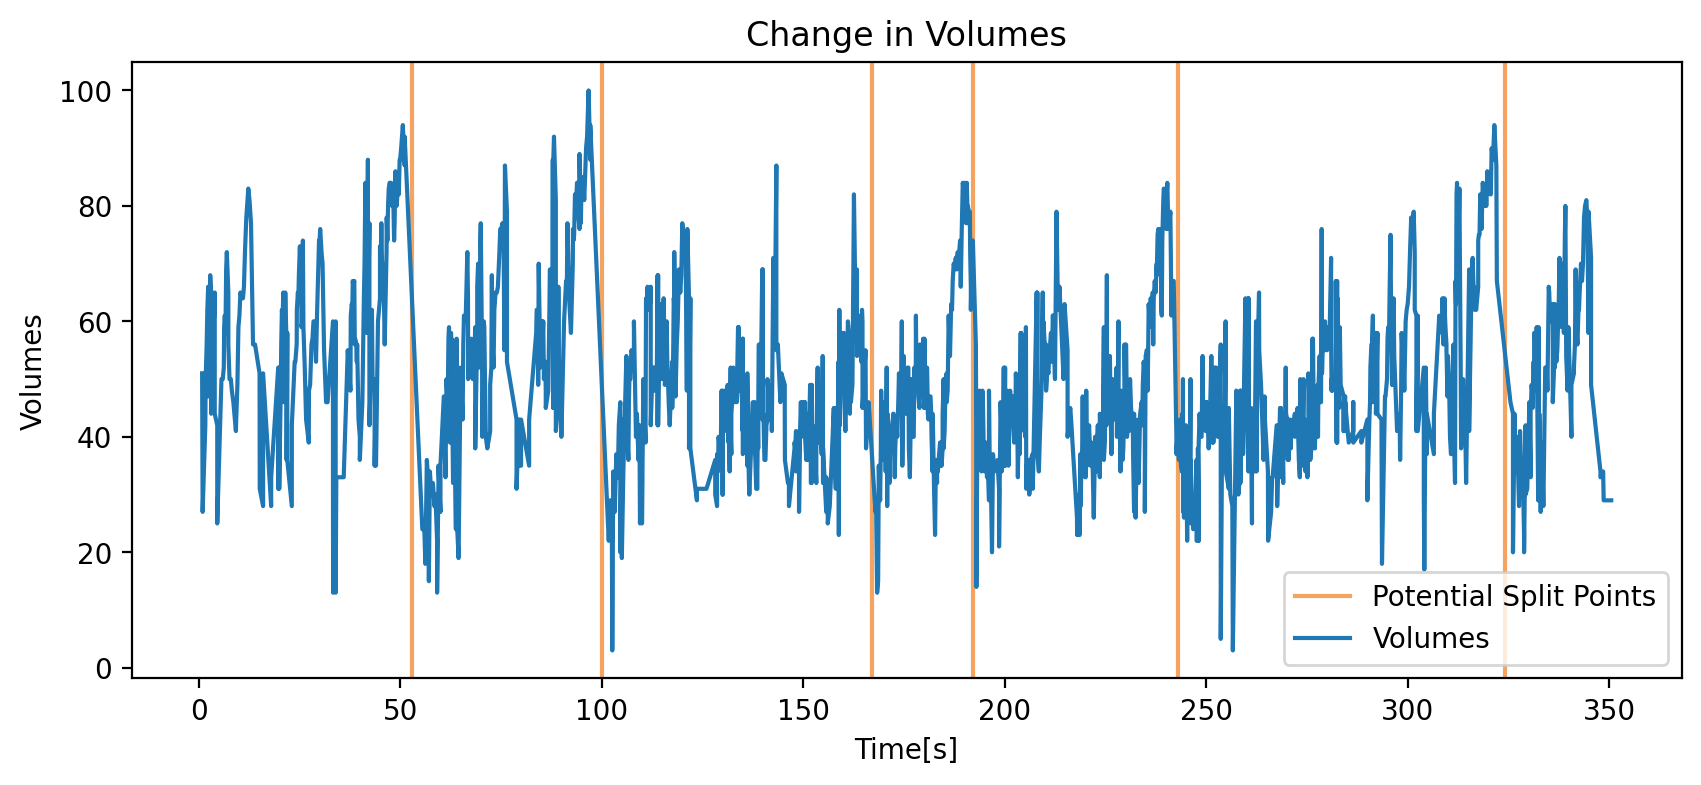

In [134]:
list_time_second = [offset_to_seconds(x, tempo) for x in list_time]
plt.figure(figsize=(10, 4))
plt.title("Change in Volumes")
plt.ylabel("Volumes")
plt.xlabel("Time[s]")
split_pont = [53, 100, 167, 192, 243, 324]
for x in split_pont:
    plt.axvline(x=x, color="sandybrown", linestyle = "-", label="Potential Split Points")
plt.plot(list_time_second, list_volumes, label="Volumes")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

### Task C3

### Task C4